In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:

    
# FUNCTIONS NEEDED FOR ALL MODELS  ============================================

# function slightly modified from https://nlpforhackers.io/topic-modeling/

def reconstruct_abstract(x):
    return " ".join(x)

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)

def return_top_topics(model, vectorizer, top_n=5):
        ret = []
        for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
            print_list = [vectorizer.get_feature_names()[i].title()  
                        for i in topic.argsort()[:-top_n - 1:-1]]
            ret.append("Topic %d: "%(idx+1)+", ".join(print_list))
        return ret


In [4]:
# DATA INGESTION =========================================================



# import entire dataset

with open(r'../../data/final/final_dataset_7-20.pkl', 'rb') as fp:
    f = pickle.load(fp)
#f = pd.read_csv('../../data/original/working_federal_reporter_2020.csv',engine='python')
f["PROJECT_START_YEAR"] = pd.to_datetime(f["PROJECT_START_DATE"])
f["PROJECT_START_YEAR"] = f["PROJECT_START_YEAR"].apply(lambda x : x.year)
f.loc[pd.isnull(f["PROJECT_START_YEAR"]),"PROJECT_START_YEAR"] = f.loc[pd.isnull(f["PROJECT_START_YEAR"]),"FY.y"]
f["PROJECT_START_YEAR"] = f["PROJECT_START_YEAR"].apply(lambda x : int(x))
df = f[pd.notnull(f["ABSTRACT"]) & (f["PROJECT_START_YEAR"] >= 2008)]#TextCleaning.remove_nulls(raw_df, "ABSTRACT")
#df = df.drop_duplicates()#TextCleaning.remove_duplicates(df)
#Random 20% of dataset:
df_samp = df.sample(frac = .2).reset_index()

#docs = df_samp["ABSTRACT"]
docs = df_samp["final_frqwds_removed"]
docs = docs.apply(lambda x : reconstruct_abstract(x))

In [5]:
# CREATE DOC-TERM MATRIX  ============================================================================

vectorizer = CountVectorizer()#CountVectorizer(max_df=0.4, min_df=3, lowercase=False, max_features=int(len(docs)/2))
doc_term_matrix = vectorizer.fit_transform(docs)


In [6]:
# NMF RUNS ===================================================================================

# create model
num_topics = 15

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 0)
nmf_model.fit_transform(doc_term_matrix)
t2 = time.time()

print(f"  Model time: {t2-t1}")

# print out topics

print_topics(nmf_model, vectorizer, top_n=5)

        


  Model time: 56.313249349594116

Topic 0:
('cell', 48.41416755482447)
('stem', 3.5035882712493716)
('immune', 1.7377988658683694)
('differentiation', 1.6925868722051935)
('tissue', 1.5853138113261642)

Topic 1:
('gene', 30.930694458141915)
('genetic', 7.398417897774527)
('dna', 6.17635575517116)
('genome', 4.131454347899744)
('human', 4.064363471587444)

Topic 2:
('cancer', 28.94466305554345)
('breast', 5.705786435498365)
('prostate', 4.0524232043149055)
('lung', 1.9609630905050903)
('woman', 1.406883041238951)

Topic 3:
('protein', 27.128470279564166)
('bind', 5.015359202402236)
('dna', 3.531931860679333)
('interaction', 3.5229402801548986)
('rna', 3.060721214566825)

Topic 4:
('student', 19.235056004545683)
('science', 7.3325215571822095)
('school', 4.508121798532335)
('stem', 4.366549169115123)
('education', 3.925399568208247)

Topic 5:
('hiv', 25.723708837633033)
('infect', 2.707526162102011)
('infection', 2.1885376485973738)
('drug', 2.1313058373234353)
('aids', 1.781057162082974

In [7]:
#Create transformed Doc-Term Matrix to allow Document-Topic distribution analysis
leg = return_top_topics(nmf_model, vectorizer, top_n=5)
doc_topic = nmf_model.transform(doc_term_matrix)

In [8]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic)
#topic_frame["ABSTRACT"] = df_samp["ABSTRACT"]
topic_frame["FY"] = df_samp["PROJECT_START_YEAR"]
topic_frame["FY"] = topic_frame["FY"].apply(lambda x : np.int64(x))
topic_frame = topic_frame.groupby("FY").mean().reset_index()
topic_frame.sort_values(by = "FY")

,FY,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2008,0.030612,0.021895,0.018723,0.028807,0.023672,0.011733,0.021229,0.024592,0.021411,0.016136,0.023309,0.016631,0.011103,0.038921,0.016935
1,2009,0.035523,0.023472,0.023689,0.029631,0.027046,0.011097,0.023145,0.032577,0.023685,0.017918,0.025911,0.018116,0.012464,0.042066,0.017378
2,2010,0.036661,0.023512,0.026256,0.030756,0.024941,0.012549,0.024588,0.037710,0.026302,0.019088,0.026905,0.019822,0.014006,0.041942,0.019437
3,2011,0.037309,0.022107,0.026637,0.028634,0.025747,0.013428,0.025506,0.037272,0.025352,0.019410,0.028565,0.019329,0.014895,0.042033,0.017771
4,2012,0.036114,0.021321,0.024803,0.025851,0.028404,0.013878,0.027404,0.039028,0.026675,0.018757,0.027421,0.020873,0.013928,0.046251,0.019312
5,2013,0.031442,0.020116,0.024225,0.021982,0.030819,0.012228,0.023361,0.026083,0.021658,0.017095,0.028027,0.016656,0.012603,0.048205,0.016131
6,2014,0.033535,0.019093,0.025297,0.023599,0.030709,0.012264,0.025141,0.026444,0.023451,0.016720,0.028710,0.017979,0.013006,0.049778,0.016913
7,2015,0.031981,0.018806,0.025098,0.022703,0.031765,0.011354,0.024830,0.026488,0.023316,0.017012,0.029483,0.017817,0.013366,0.052251,0.016920
8,2016,0.031672,0.019044,0.024033,0.022166,0.033704,0.011913,0.025268,0.027076,0.024865,0.016791,0.032278,0.017575,0.011499,0.052928,0.017058
9,2017,0.031192,0.019207,0.024269,0.022724,0.034784,0.012681,0.025719,0.026700,0.025849,0.017371,0.030993,0.017219,0.012284,0.051724,0.016995


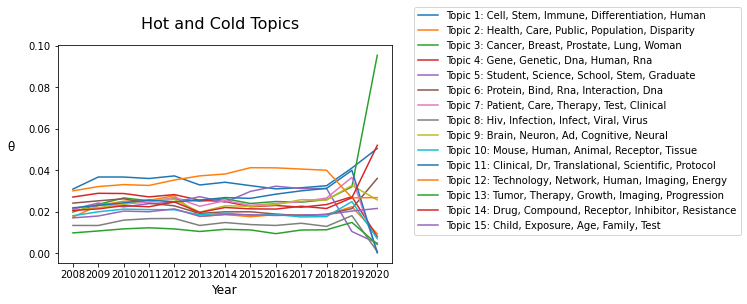

In [12]:
#Make Graphs
#leg = []

fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)
for n in range(num_topics):
    ax.plot(topic_frame["FY"],topic_frame[n])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_frame["FY"].min(), topic_frame["FY"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('θ', fontsize=12, rotation = 0)
ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [11]:
hotness = topic_frame.loc[(topic_frame["FY"] == 2020)].values - topic_frame.loc[(topic_frame["FY"] == 2019)].values
hotness

array([[ 1.00000000e+00,  4.00799919e-02,  2.54687733e-02,
        -2.59165715e-02,  3.09586645e-03,  4.11649591e-02,
        -1.30100457e-02, -2.46004791e-02, -2.23340966e-02,
        -3.74049364e-04, -1.08138409e-02, -3.23240231e-02,
        -9.13029855e-03,  7.07724723e-03, -2.26245643e-02,
        -6.55319138e-03]])

In [12]:
#Make Graphs
#leg = []


hotness = topic_frame.loc[(topic_frame["FY"] == 2020)].values - topic_frame.loc[(topic_frame["FY"] == 2019)].values
hotness_cat = hotness[0][1:]
hot_order = hotness[0][1:]
hot_order.sort()
top_hot = hot_order[3:]
bottom_hot = hot_order[:-3]
hotness

array([[ 1.00000000e+00, -3.23240231e-02, -2.59165715e-02,
        -2.46004791e-02, -2.26245643e-02, -2.23340966e-02,
        -1.30100457e-02, -1.08138409e-02, -9.13029855e-03,
        -6.55319138e-03, -3.74049364e-04,  3.09586645e-03,
         7.07724723e-03,  2.54687733e-02,  4.00799919e-02,
         4.11649591e-02]])

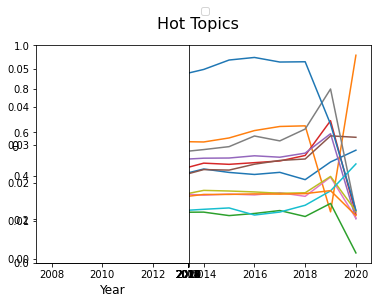

In [16]:
#Make Graphs
#leg = []

fig = plt.figure()
fig.suptitle('Hot Topics', fontsize=16)
ax_hot = fig.add_subplot(111)
ax_cold = fig.add_subplot(121)


#hotness = topic_frame_
for n in range(num_topics):
    if hotness_cat[n] in top_hot:
        ax_hot.plot(topic_frame["FY"],topic_frame[n])
    else:
        continue
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_frame["FY"].min(), topic_frame["FY"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('θ', fontsize=12, rotation = 0)
ax_hot.yaxis.set_label_coords(-0.14,0.5)
ax_cold.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()